In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/sample_submission.csv
data/data_Y.csv
data/data_X.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import random
from tqdm.autonotebook import tqdm
import datetime 

from scipy.stats import norm

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Support warning
import warnings
warnings.filterwarnings("ignore")

<ipython-input-2-089c90da6b98>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import torch
from torch import nn
from torch.utils import data as data_utils
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ExponentialLR

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [5]:
model_params = {
    'model_type': 'dev',
    'model_type_batch': 1, 
    'model_type_online': 0, 
    'batch_size': 64, 
    'seed': 777,
    'version': 1,
    'window': 5,
    'lag_type': 'm',
    'test_from': datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
}

In [6]:
def global_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    str_seed = str(seed)
    os.environ["PYTHONHASHSEED"] = str_seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
global_seed(model_params['seed'])

In [7]:
X_data = pd.read_csv('data/data_X.csv', sep=',')
X_data = X_data.sort_values('date_time')
X_data.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data
0,2015-01-01 00:00:00,212,210,211,347,353,347,474,473,481,346,348,355,241,241,243,167.85,9.22
1,2015-01-01 00:01:00,212,211,211,346,352,346,475,473,481,349,348,355,241,241,243,162.51,9.22
2,2015-01-01 00:02:00,212,211,211,345,352,346,476,473,481,352,349,355,242,241,242,164.99,9.22
3,2015-01-01 00:03:00,213,211,211,344,351,346,477,473,481,355,349,355,242,241,242,167.34,9.22
4,2015-01-01 00:04:00,213,211,211,343,350,346,478,473,482,358,349,355,243,241,242,163.04,9.22


In [8]:
X_data.shape

(2103841, 18)

In [9]:
X_data['date_time'] = pd.to_datetime(X_data['date_time'])

In [10]:
data_tmp_columns = X_data.columns.tolist()

In [11]:
window = model_params['window']

with tqdm(total=window) as pbar:
    for i in range(window):
        X_data_tmp = X_data[data_tmp_columns].copy()
        X_data_tmp['date_time_new'] = X_data_tmp['date_time']
        X_data_tmp['date_time'] = X_data_tmp['date_time'] + np.timedelta64(i+1, 'm')
        X_data_tmp.columns = [X_data_tmp.columns[0]] + list(map(lambda x: x+'_'+str(i+1), X_data_tmp.columns[1:]))
        X_data = X_data.merge(X_data_tmp, how='inner', left_on=['date_time'], right_on=['date_time'])
        pbar.write('processed: %d' %(1 + i))
        pbar.update(1)

processed: 1
processed: 2
processed: 3
processed: 4
processed: 5



In [12]:
X_data[[c for c in X_data.columns if 'date_time' in c]].head()

,date_time,date_time_new_1,date_time_new_2,date_time_new_3,date_time_new_4,date_time_new_5
0,2015-01-01 00:15:00,2015-01-01 00:14:00,2015-01-01 00:13:00,2015-01-01 00:12:00,2015-01-01 00:11:00,2015-01-01 00:10:00
1,2015-01-01 00:16:00,2015-01-01 00:15:00,2015-01-01 00:14:00,2015-01-01 00:13:00,2015-01-01 00:12:00,2015-01-01 00:11:00
2,2015-01-01 00:17:00,2015-01-01 00:16:00,2015-01-01 00:15:00,2015-01-01 00:14:00,2015-01-01 00:13:00,2015-01-01 00:12:00
3,2015-01-01 00:18:00,2015-01-01 00:17:00,2015-01-01 00:16:00,2015-01-01 00:15:00,2015-01-01 00:14:00,2015-01-01 00:13:00
4,2015-01-01 00:19:00,2015-01-01 00:18:00,2015-01-01 00:17:00,2015-01-01 00:16:00,2015-01-01 00:15:00,2015-01-01 00:14:00


In [13]:
X_data.drop([c for c in X_data.columns if 'date_time_' in c], axis=1, inplace=True)

In [14]:
X_data.shape

(2103826, 103)

In [15]:
X_data.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,T_data_1_1_1,T_data_1_2_1,T_data_1_3_1,T_data_2_1_1,T_data_2_2_1,T_data_2_3_1,T_data_3_1_1,T_data_3_2_1,T_data_3_3_1,T_data_4_1_1,T_data_4_2_1,T_data_4_3_1,T_data_5_1_1,T_data_5_2_1,T_data_5_3_1,H_data_1,AH_data_1,T_data_1_1_2,T_data_1_2_2,T_data_1_3_2,T_data_2_1_2,T_data_2_2_2,T_data_2_3_2,T_data_3_1_2,T_data_3_2_2,T_data_3_3_2,T_data_4_1_2,T_data_4_2_2,T_data_4_3_2,T_data_5_1_2,T_data_5_2_2,T_data_5_3_2,H_data_2,AH_data_2,T_data_1_1_3,T_data_1_2_3,T_data_1_3_3,T_data_2_1_3,T_data_2_2_3,T_data_2_3_3,T_data_3_1_3,T_data_3_2_3,T_data_3_3_3,T_data_4_1_3,T_data_4_2_3,T_data_4_3_3,T_data_5_1_3,T_data_5_2_3,T_data_5_3_3,H_data_3,AH_data_3,T_data_1_1_4,T_data_1_2_4,T_data_1_3_4,T_data_2_1_4,T_data_2_2_4,T_data_2_3_4,T_data_3_1_4,T_data_3_2_4,T_data_3_3_4,T_data_4_1_4,T_data_4_2_4,T_data_4_3_4,T_data_5_1_4,T_data_5_2_4,T_data_5_3_4,H_data_4,AH_data_4,T_data_1_1_5,T_data_1_2_5,T_data_1_3_5,T_data_2_1_5,T_data_2_2_5,T_data_2_3_5,T_data_3_1_5,T_data_3_2_5,T_data_3_3_5,T_data_4_1_5,T_data_4_2_5,T_data_4_3_5,T_data_5_1_5,T_data_5_2_5,T_data_5_3_5,H_data_5,AH_data_5
0,2015-01-01 00:15:00,214,213,211,332,342,344,490,473,484,379,352,352,246,241,241,162.94,9.22,214,213,211,333,343,344,489,473,484,378,351,353,246,241,241,171.24,9.22,214,213,211,334,344,344,488,473,483,377,351,353,246,241,241,165.12,9.22,214,213,211,335,345,345,487,473,483,375,351,353,246,241,241,168.25,9.22,214,213,211,336,345,345,486,473,483,373,351,353,245,241,241,167.51,9.22,213,212,211,337,346,345,485,473,483,371,350,353,245,241,241,161.27,9.22
1,2015-01-01 00:16:00,214,213,211,331,342,344,491,473,484,381,352,352,247,241,241,166.37,9.22,214,213,211,332,342,344,490,473,484,379,352,352,246,241,241,162.94,9.22,214,213,211,333,343,344,489,473,484,378,351,353,246,241,241,171.24,9.22,214,213,211,334,344,344,488,473,483,377,351,353,246,241,241,165.12,9.22,214,213,211,335,345,345,487,473,483,375,351,353,246,241,241,168.25,9.22,214,213,211,336,345,345,486,473,483,373,351,353,245,241,241,167.51,9.22
2,2015-01-01 00:17:00,214,213,211,330,341,344,492,473,484,382,352,352,247,241,241,165.42,9.22,214,213,211,331,342,344,491,473,484,381,352,352,247,241,241,166.37,9.22,214,213,211,332,342,344,490,473,484,379,352,352,246,241,241,162.94,9.22,214,213,211,333,343,344,489,473,484,378,351,353,246,241,241,171.24,9.22,214,213,211,334,344,344,488,473,483,377,351,353,246,241,241,165.12,9.22,214,213,211,335,345,345,487,473,483,375,351,353,246,241,241,168.25,9.22
3,2015-01-01 00:18:00,214,214,211,329,340,344,493,473,484,383,352,352,247,241,241,162.05,9.22,214,213,211,330,341,344,492,473,484,382,352,352,247,241,241,165.42,9.22,214,213,211,331,342,344,491,473,484,381,352,352,247,241,241,166.37,9.22,214,213,211,332,342,344,490,473,484,379,352,352,246,241,241,162.94,9.22,214,213,211,333,343,344,489,473,484,378,351,353,246,241,241,171.24,9.22,214,213,211,334,344,344,488,473,483,377,351,353,246,241,241,165.12,9.22
4,2015-01-01 00:19:00,214,214,211,328,339,344,494,473,485,383,352,352,247,241,241,163.01,9.22,214,214,211,329,340,344,493,473,484,383,352,352,247,241,241,162.05,9.22,214,213,211,330,341,344,492,473,484,382,352,352,247,241,241,165.42,9.22,214,213,211,331,342,344,491,473,484,381,352,352,247,241,241,166.37,9.22,214,213,211,332,342,344,490,473,484,379,352,352,246,241,241,162.94,9.22,214,213,211,333,343,344,489,473,484,378,351,353,246,241,241,171.24,9.22


In [16]:
Y_train = pd.read_csv('data/data_Y.csv', sep=',')
Y_train['date_time'] = pd.to_datetime(Y_train['date_time'])
Y_train.head()

,date_time,quality
0,2015-01-04 00:05:00,392
1,2015-01-04 01:05:00,384
2,2015-01-04 02:05:00,393
3,2015-01-04 03:05:00,399
4,2015-01-04 04:05:00,400


In [17]:
Y_train.shape

(29184, 2)

In [18]:
Y_submit = pd.read_csv('data/sample_submission.csv', sep=',')
Y_submit['date_time'] = pd.to_datetime(Y_submit['date_time'])
Y_submit.head()

,date_time,quality
0,2018-05-04 00:05:00,420
1,2018-05-04 01:05:00,420
2,2018-05-04 02:05:00,420
3,2018-05-04 03:05:00,420
4,2018-05-04 04:05:00,420


In [19]:
Y_submit.shape

(5808, 2)

In [20]:
train_df = X_data.merge(Y_train, left_on='date_time', right_on='date_time')
predict_df = X_data.merge(Y_submit, left_on='date_time', right_on='date_time').drop('quality', axis=1)

In [21]:
train_df.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,T_data_1_1_1,T_data_1_2_1,T_data_1_3_1,T_data_2_1_1,T_data_2_2_1,T_data_2_3_1,T_data_3_1_1,T_data_3_2_1,T_data_3_3_1,T_data_4_1_1,T_data_4_2_1,T_data_4_3_1,T_data_5_1_1,T_data_5_2_1,T_data_5_3_1,H_data_1,AH_data_1,T_data_1_1_2,T_data_1_2_2,T_data_1_3_2,T_data_2_1_2,T_data_2_2_2,T_data_2_3_2,T_data_3_1_2,T_data_3_2_2,T_data_3_3_2,T_data_4_1_2,T_data_4_2_2,T_data_4_3_2,T_data_5_1_2,T_data_5_2_2,T_data_5_3_2,H_data_2,AH_data_2,T_data_1_1_3,T_data_1_2_3,T_data_1_3_3,T_data_2_1_3,T_data_2_2_3,T_data_2_3_3,T_data_3_1_3,T_data_3_2_3,T_data_3_3_3,T_data_4_1_3,T_data_4_2_3,T_data_4_3_3,T_data_5_1_3,T_data_5_2_3,T_data_5_3_3,H_data_3,AH_data_3,T_data_1_1_4,T_data_1_2_4,T_data_1_3_4,T_data_2_1_4,T_data_2_2_4,T_data_2_3_4,T_data_3_1_4,T_data_3_2_4,T_data_3_3_4,T_data_4_1_4,T_data_4_2_4,T_data_4_3_4,T_data_5_1_4,T_data_5_2_4,T_data_5_3_4,H_data_4,AH_data_4,T_data_1_1_5,T_data_1_2_5,T_data_1_3_5,T_data_2_1_5,T_data_2_2_5,T_data_2_3_5,T_data_3_1_5,T_data_3_2_5,T_data_3_3_5,T_data_4_1_5,T_data_4_2_5,T_data_4_3_5,T_data_5_1_5,T_data_5_2_5,T_data_5_3_5,H_data_5,AH_data_5,quality
0,2015-01-04 00:05:00,277,326,273,322,335,352,505,501,670,326,379,337,231,236,242,153.77,7.90,277,327,273,322,335,352,505,501,667,326,378,337,231,236,242,155.45,7.90,276,328,273,322,335,351,505,501,664,326,378,337,231,236,242,154.12,7.90,276,328,272,322,335,351,505,501,661,325,377,337,231,236,243,158.29,7.90,276,329,272,322,335,351,505,501,658,325,377,337,231,236,243,152.62,7.90,276,330,272,323,335,351,505,501,655,325,377,337,231,236,243,157.74,7.90,392
1,2015-01-04 01:05:00,277,253,272,320,333,355,500,501,687,337,396,335,234,242,230,158.27,6.96,277,254,272,320,333,356,500,501,690,337,396,335,234,242,230,156.00,6.96,277,256,272,320,333,356,500,501,693,336,396,336,234,241,230,159.17,6.96,277,257,272,320,333,356,500,501,695,336,396,336,234,241,230,156.39,6.96,277,259,272,320,333,356,500,501,697,336,396,336,233,241,230,156.31,6.96,277,260,272,320,333,356,500,502,700,336,395,336,233,241,230,158.70,6.96,384
2,2015-01-04 02:05:00,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,153.36,7.29,262,218,260,326,336,330,505,499,443,347,399,332,243,251,240,154.15,7.29,263,218,260,326,336,331,505,499,442,347,399,333,243,251,239,156.51,7.29,264,218,261,326,336,332,505,499,442,347,399,333,242,251,239,156.11,7.29,264,218,261,325,336,332,505,499,442,347,399,333,242,250,239,155.23,7.29,265,218,261,325,336,333,504,499,443,347,399,333,242,250,238,155.58,7.29,393
3,2015-01-04 03:05:00,243,238,252,327,329,308,520,498,540,342,387,334,257,258,246,153.21,7.11,243,238,252,327,329,308,520,498,540,342,387,334,256,258,246,154.79,7.11,243,237,252,327,329,308,520,498,539,342,387,334,256,258,246,154.73,7.11,243,237,252,327,329,308,520,498,538,342,388,334,256,258,246,161.53,7.11,243,237,252,327,330,308,519,498,538,342,388,333,256,258,246,156.34,7.11,243,237,252,327,330,308,519,498,537,342,388,333,256,258,247,155.93,7.11,399
4,2015-01-04 04:05:00,236,238,245,323,320,318,522,501,524,343,371,344,264,263,265,195.71,7.97,236,238,245,323,320,318,522,501,525,343,371,344,264,263,264,195.60,7.97,236,238,245,323,321,318,523,501,525,343,371,344,264,263,263,191.37,7.97,237,238,246,324,321,318,523,501,526,343,371,343,264,263,262,196.53,7.97,237,238,246,324,321,318,523,501,526,343,372,343,264,263,261,194.83,7.97,237,239,246,324,321,317,523,501,527,342,372,343,263,263,261,191.98,7.97,400


In [22]:
predict_df.head()

,date_time,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,T_data_1_1_1,T_data_1_2_1,T_data_1_3_1,T_data_2_1_1,T_data_2_2_1,T_data_2_3_1,T_data_3_1_1,T_data_3_2_1,T_data_3_3_1,T_data_4_1_1,T_data_4_2_1,T_data_4_3_1,T_data_5_1_1,T_data_5_2_1,T_data_5_3_1,H_data_1,AH_data_1,T_data_1_1_2,T_data_1_2_2,T_data_1_3_2,T_data_2_1_2,T_data_2_2_2,T_data_2_3_2,T_data_3_1_2,T_data_3_2_2,T_data_3_3_2,T_data_4_1_2,T_data_4_2_2,T_data_4_3_2,T_data_5_1_2,T_data_5_2_2,T_data_5_3_2,H_data_2,AH_data_2,T_data_1_1_3,T_data_1_2_3,T_data_1_3_3,T_data_2_1_3,T_data_2_2_3,T_data_2_3_3,T_data_3_1_3,T_data_3_2_3,T_data_3_3_3,T_data_4_1_3,T_data_4_2_3,T_data_4_3_3,T_data_5_1_3,T_data_5_2_3,T_data_5_3_3,H_data_3,AH_data_3,T_data_1_1_4,T_data_1_2_4,T_data_1_3_4,T_data_2_1_4,T_data_2_2_4,T_data_2_3_4,T_data_3_1_4,T_data_3_2_4,T_data_3_3_4,T_data_4_1_4,T_data_4_2_4,T_data_4_3_4,T_data_5_1_4,T_data_5_2_4,T_data_5_3_4,H_data_4,AH_data_4,T_data_1_1_5,T_data_1_2_5,T_data_1_3_5,T_data_2_1_5,T_data_2_2_5,T_data_2_3_5,T_data_3_1_5,T_data_3_2_5,T_data_3_3_5,T_data_4_1_5,T_data_4_2_5,T_data_4_3_5,T_data_5_1_5,T_data_5_2_5,T_data_5_3_5,H_data_5,AH_data_5
0,2018-05-04 00:05:00,258,261,256,347,337,352,474,434,443,336,321,516,248,247,236,154.93,6.81,258,260,256,347,329,352,474,434,443,336,321,515,248,247,236,157.05,6.81,258,260,257,347,322,352,474,434,442,337,321,513,248,248,237,156.38,6.81,258,260,257,347,316,352,474,435,442,337,321,511,249,248,237,157.44,6.81,258,260,257,347,311,352,473,435,442,337,322,508,249,248,237,154.84,6.81,258,260,257,347,307,352,473,435,442,338,322,505,249,249,237,156.62,6.81
1,2018-05-04 01:05:00,255,263,258,351,-162,359,460,441,454,320,319,341,238,255,236,156.52,7.89,255,263,258,351,-160,359,461,441,454,320,319,340,239,255,236,155.70,7.89,255,263,257,351,-158,359,461,440,453,321,319,338,239,255,235,157.88,7.89,256,263,257,351,-156,359,462,440,453,321,319,336,239,255,235,154.33,7.89,256,263,257,351,-153,359,463,440,453,321,318,334,239,255,235,154.83,7.89,256,263,256,351,-150,359,463,439,453,321,318,332,239,255,235,154.32,7.89
2,2018-05-04 02:05:00,259,261,288,363,104,374,482,474,483,343,325,307,226,249,255,153.37,6.16,258,261,289,363,98,374,482,473,482,342,325,307,227,249,255,156.88,6.16,258,262,289,362,92,373,482,473,482,342,325,307,227,249,255,157.30,6.16,258,262,290,362,86,373,482,472,481,341,325,308,227,249,255,157.57,6.16,258,262,290,362,79,373,482,471,480,340,324,308,227,249,255,157.38,6.16,258,262,291,362,73,372,482,471,480,339,324,308,227,249,254,156.71,6.16
3,2018-05-04 03:05:00,272,266,279,373,338,386,495,510,503,330,307,323,213,245,250,161.45,7.53,272,266,278,373,337,386,495,509,503,331,308,323,213,245,250,162.46,7.53,272,266,278,373,335,386,495,509,503,332,309,323,213,245,250,166.03,7.53,272,266,277,373,333,386,494,509,503,333,310,323,214,244,250,152.24,7.53,271,265,276,373,331,386,494,508,502,334,311,323,214,244,250,156.92,7.53,271,265,275,373,329,387,494,508,502,335,311,322,214,244,250,156.61,7.53
4,2018-05-04 04:05:00,287,290,309,373,352,358,512,514,499,317,220,319,215,265,249,165.22,6.93,287,290,309,373,352,357,512,514,499,317,222,319,215,265,249,165.68,6.93,287,289,309,373,352,357,511,514,499,316,224,320,215,265,249,165.08,6.93,286,289,308,373,352,357,511,514,500,316,226,320,215,265,249,166.68,6.93,286,289,308,373,352,358,511,514,500,315,228,320,215,264,249,166.72,6.93,286,288,308,373,352,358,511,514,500,315,230,321,214,264,249,165.73,6.93


In [23]:
train_df.shape, predict_df.shape

((29184, 104), (5808, 103))

In [24]:
assert train_df.shape[0] == Y_train.shape[0]
assert predict_df.shape[0] == Y_submit.shape[0]

# EDA

In [25]:
train_df.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,T_data_1_1_1,T_data_1_2_1,T_data_1_3_1,T_data_2_1_1,T_data_2_2_1,T_data_2_3_1,T_data_3_1_1,T_data_3_2_1,T_data_3_3_1,T_data_4_1_1,T_data_4_2_1,T_data_4_3_1,T_data_5_1_1,T_data_5_2_1,T_data_5_3_1,H_data_1,AH_data_1,T_data_1_1_2,T_data_1_2_2,T_data_1_3_2,T_data_2_1_2,T_data_2_2_2,T_data_2_3_2,T_data_3_1_2,T_data_3_2_2,T_data_3_3_2,T_data_4_1_2,T_data_4_2_2,T_data_4_3_2,T_data_5_1_2,T_data_5_2_2,T_data_5_3_2,H_data_2,AH_data_2,T_data_1_1_3,T_data_1_2_3,T_data_1_3_3,T_data_2_1_3,T_data_2_2_3,T_data_2_3_3,T_data_3_1_3,T_data_3_2_3,T_data_3_3_3,T_data_4_1_3,T_data_4_2_3,T_data_4_3_3,T_data_5_1_3,T_data_5_2_3,T_data_5_3_3,H_data_3,AH_data_3,T_data_1_1_4,T_data_1_2_4,T_data_1_3_4,T_data_2_1_4,T_data_2_2_4,T_data_2_3_4,T_data_3_1_4,T_data_3_2_4,T_data_3_3_4,T_data_4_1_4,T_data_4_2_4,T_data_4_3_4,T_data_5_1_4,T_data_5_2_4,T_data_5_3_4,H_data_4,AH_data_4,T_data_1_1_5,T_data_1_2_5,T_data_1_3_5,T_data_2_1_5,T_data_2_2_5,T_data_2_3_5,T_data_3_1_5,T_data_3_2_5,T_data_3_3_5,T_data_4_1_5,T_data_4_2_5,T_data_4_3_5,T_data_5_1_5,T_data_5_2_5,T_data_5_3_5,H_data_5,AH_data_5,quality
count,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.00000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000,29184.000000
mean,250.034265,249.814179,250.152584,349.803008,349.717893,349.951377,501.162932,500.918037,501.318291,348.956689,348.952063,349.67352,249.800644,249.671635,249.848890,174.750047,7.500597,250.033751,249.819353,250.151556,349.802460,349.717791,349.950384,501.162315,500.921532,501.315961,348.955249,348.958368,349.672458,249.800918,249.673485,249.848273,174.739756,7.500597,250.033066,249.820107,250.153886,349.800507,349.717277,349.952817,501.167112,500.928385,501.314967,348.956689,348.958196,349.675610,249.805167,249.675404,249.847793,174.738827,7.500597,250.034060,249.823157,250.153475,349.798177,349.716831,349.955661,501.171669,500.931709,501.316235,348.951343,348.957956,349.673760,249.805715,249.681024,249.846594,174.722696,7.500597,250.033923,249.824527,250.154228,349.799925,349.719984,349.956928,501.171806,500.936678,501.318120,348.945826,348.960355,349.675233,249.811472,249.682908,249.845018,174.724819,7.500597,250.036184,249.825521,250.153886,349.796464,349.722759,349.959087,501.170299,500.940927,501.317366,348.948465,348.963096,349.674685,249.811952,249.683217,249.840735,174.754873,7.500597,402.800747
std,32.350350,30.453885,30.635287,43.752481,41.414882,38.016812,62.418309,64.634889,61.482540,38.755415,40.172444,39.73318,30.780582,30.545967,30.630141,14.403922,1.146831,32.350807,30.457831,30.636429,43.763445,41.423836,38.017391,62.402391,64.628407,61.491110,38.751687,

In [26]:
predict_df.describe()

,T_data_1_1,T_data_1_2,T_data_1_3,T_data_2_1,T_data_2_2,T_data_2_3,T_data_3_1,T_data_3_2,T_data_3_3,T_data_4_1,T_data_4_2,T_data_4_3,T_data_5_1,T_data_5_2,T_data_5_3,H_data,AH_data,T_data_1_1_1,T_data_1_2_1,T_data_1_3_1,T_data_2_1_1,T_data_2_2_1,T_data_2_3_1,T_data_3_1_1,T_data_3_2_1,T_data_3_3_1,T_data_4_1_1,T_data_4_2_1,T_data_4_3_1,T_data_5_1_1,T_data_5_2_1,T_data_5_3_1,H_data_1,AH_data_1,T_data_1_1_2,T_data_1_2_2,T_data_1_3_2,T_data_2_1_2,T_data_2_2_2,T_data_2_3_2,T_data_3_1_2,T_data_3_2_2,T_data_3_3_2,T_data_4_1_2,T_data_4_2_2,T_data_4_3_2,T_data_5_1_2,T_data_5_2_2,T_data_5_3_2,H_data_2,AH_data_2,T_data_1_1_3,T_data_1_2_3,T_data_1_3_3,T_data_2_1_3,T_data_2_2_3,T_data_2_3_3,T_data_3_1_3,T_data_3_2_3,T_data_3_3_3,T_data_4_1_3,T_data_4_2_3,T_data_4_3_3,T_data_5_1_3,T_data_5_2_3,T_data_5_3_3,H_data_3,AH_data_3,T_data_1_1_4,T_data_1_2_4,T_data_1_3_4,T_data_2_1_4,T_data_2_2_4,T_data_2_3_4,T_data_3_1_4,T_data_3_2_4,T_data_3_3_4,T_data_4_1_4,T_data_4_2_4,T_data_4_3_4,T_data_5_1_4,T_data_5_2_4,T_data_5_3_4,H_data_4,AH_data_4,T_data_1_1_5,T_data_1_2_5,T_data_1_3_5,T_data_2_1_5,T_data_2_2_5,T_data_2_3_5,T_data_3_1_5,T_data_3_2_5,T_data_3_3_5,T_data_4_1_5,T_data_4_2_5,T_data_4_3_5,T_data_5_1_5,T_data_5_2_5,T_data_5_3_5,H_data_5,AH_data_5
count,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.00000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000,5808.000000
mean,250.778753,251.288567,250.642734,349.826963,349.685262,349.185778,500.957300,501.948003,500.849518,351.149277,351.875861,351.971935,249.383437,249.390324,248.968492,174.812361,7.492164,250.788567,251.290978,250.644800,349.819043,349.671488,349.193182,500.952479,501.956784,500.842631,351.145317,351.868285,351.977101,249.372417,249.395661,248.975895,174.854959,7.492164,250.792528,251.302342,250.654959,349.81009,349.669594,349.199897,500.950069,501.950758,500.833678,351.144628,351.866047,351.981577,249.367252,249.400999,248.972452,174.784418,7.492164,250.799070,251.305096,250.653581,349.806646,349.653753,349.197831,500.960916,501.934917,500.820248,351.154270,351.871729,351.992769,249.366563,249.397383,248.971247,174.801794,7.492164,250.793561,251.301653,250.657886,349.795627,349.652376,349.208850,500.951791,501.939910,500.815083,351.157541,351.865358,351.988464,249.360709,249.399793,248.972624,174.800367,7.492164,250.789601,251.307507,250.668044,349.783747,349.642562,349.214015,500.955062,501.930613,500.793733,351.167700,351.866563,351.991391,249.357610,249.411674,248.973829,174.851383,7.492164
std,31.038194,32.428110,30.963172,34.359251,36.603744,38.072933,67.871775,57.607375,66.304180,40.813671,33.352467,42.538979,30.628116,30.029089,31.252217,14.538668,1.152853,31.027683,32.432872,30.963786,34.352704,36.589662,38.078371,67.860404,57.665601,66.329082,40.838253,33.358013,42.529184,30.648295,30.038873,31.237213,14.538466,1.152853,31.019625,32.430252,30.961256,34.35241,36.588438,38.080233,67.85

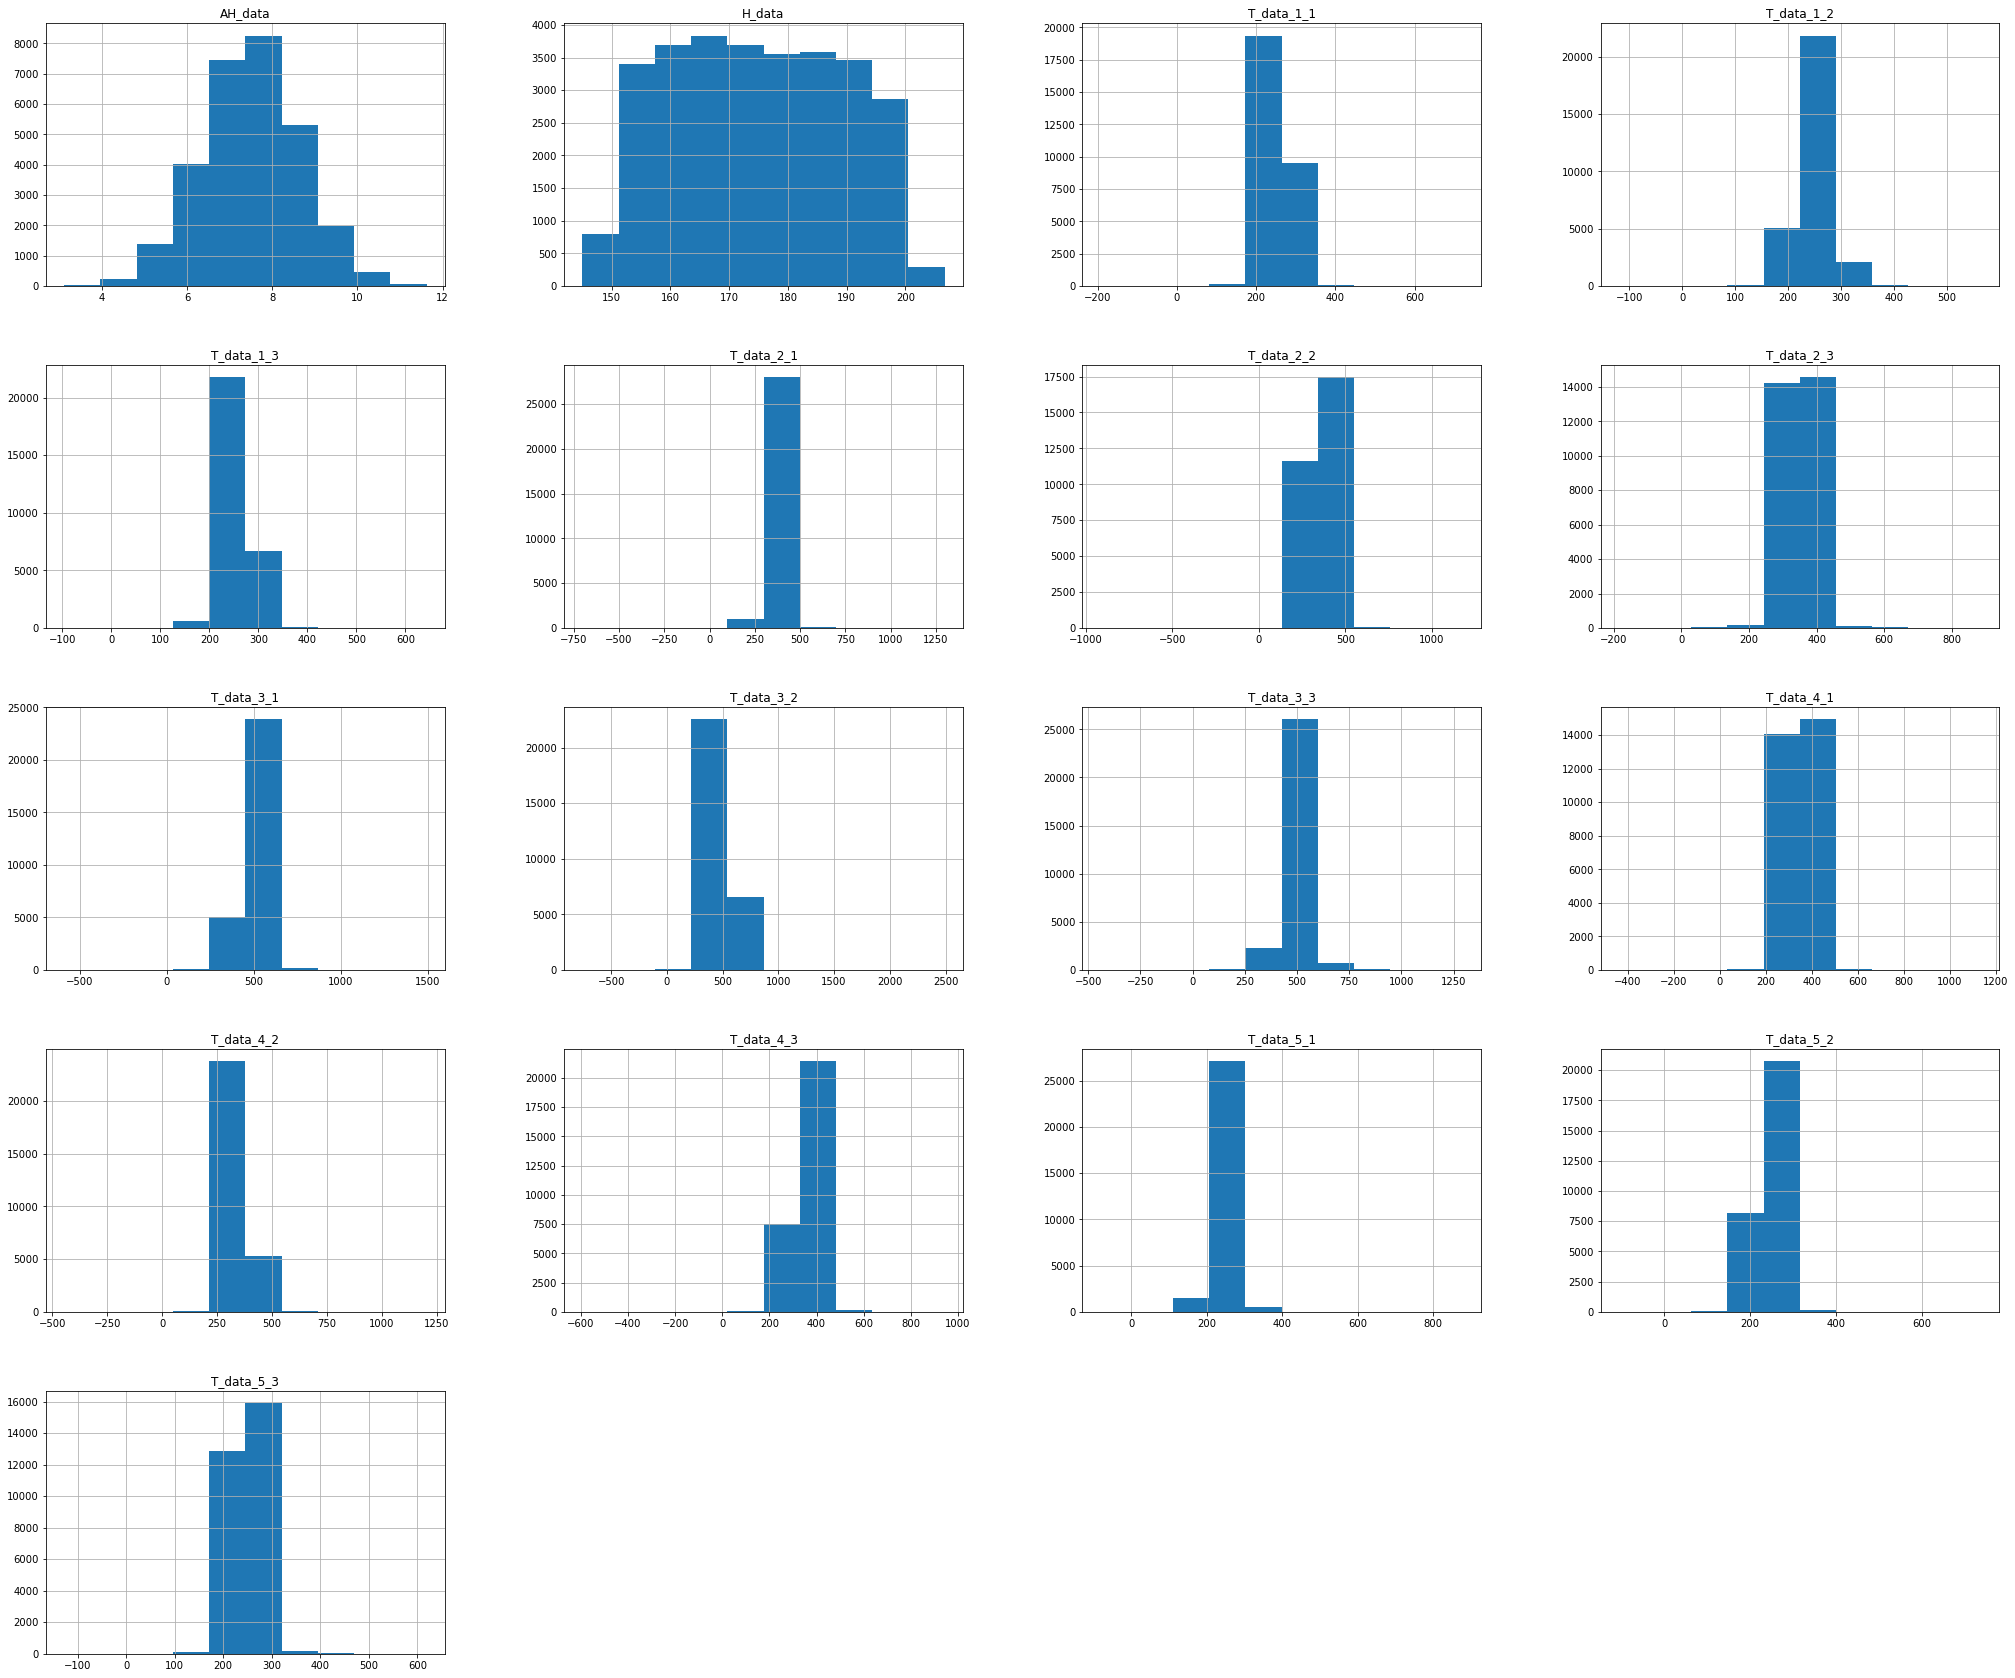

In [27]:
train_df[data_tmp_columns].hist(figsize=(35, 30));

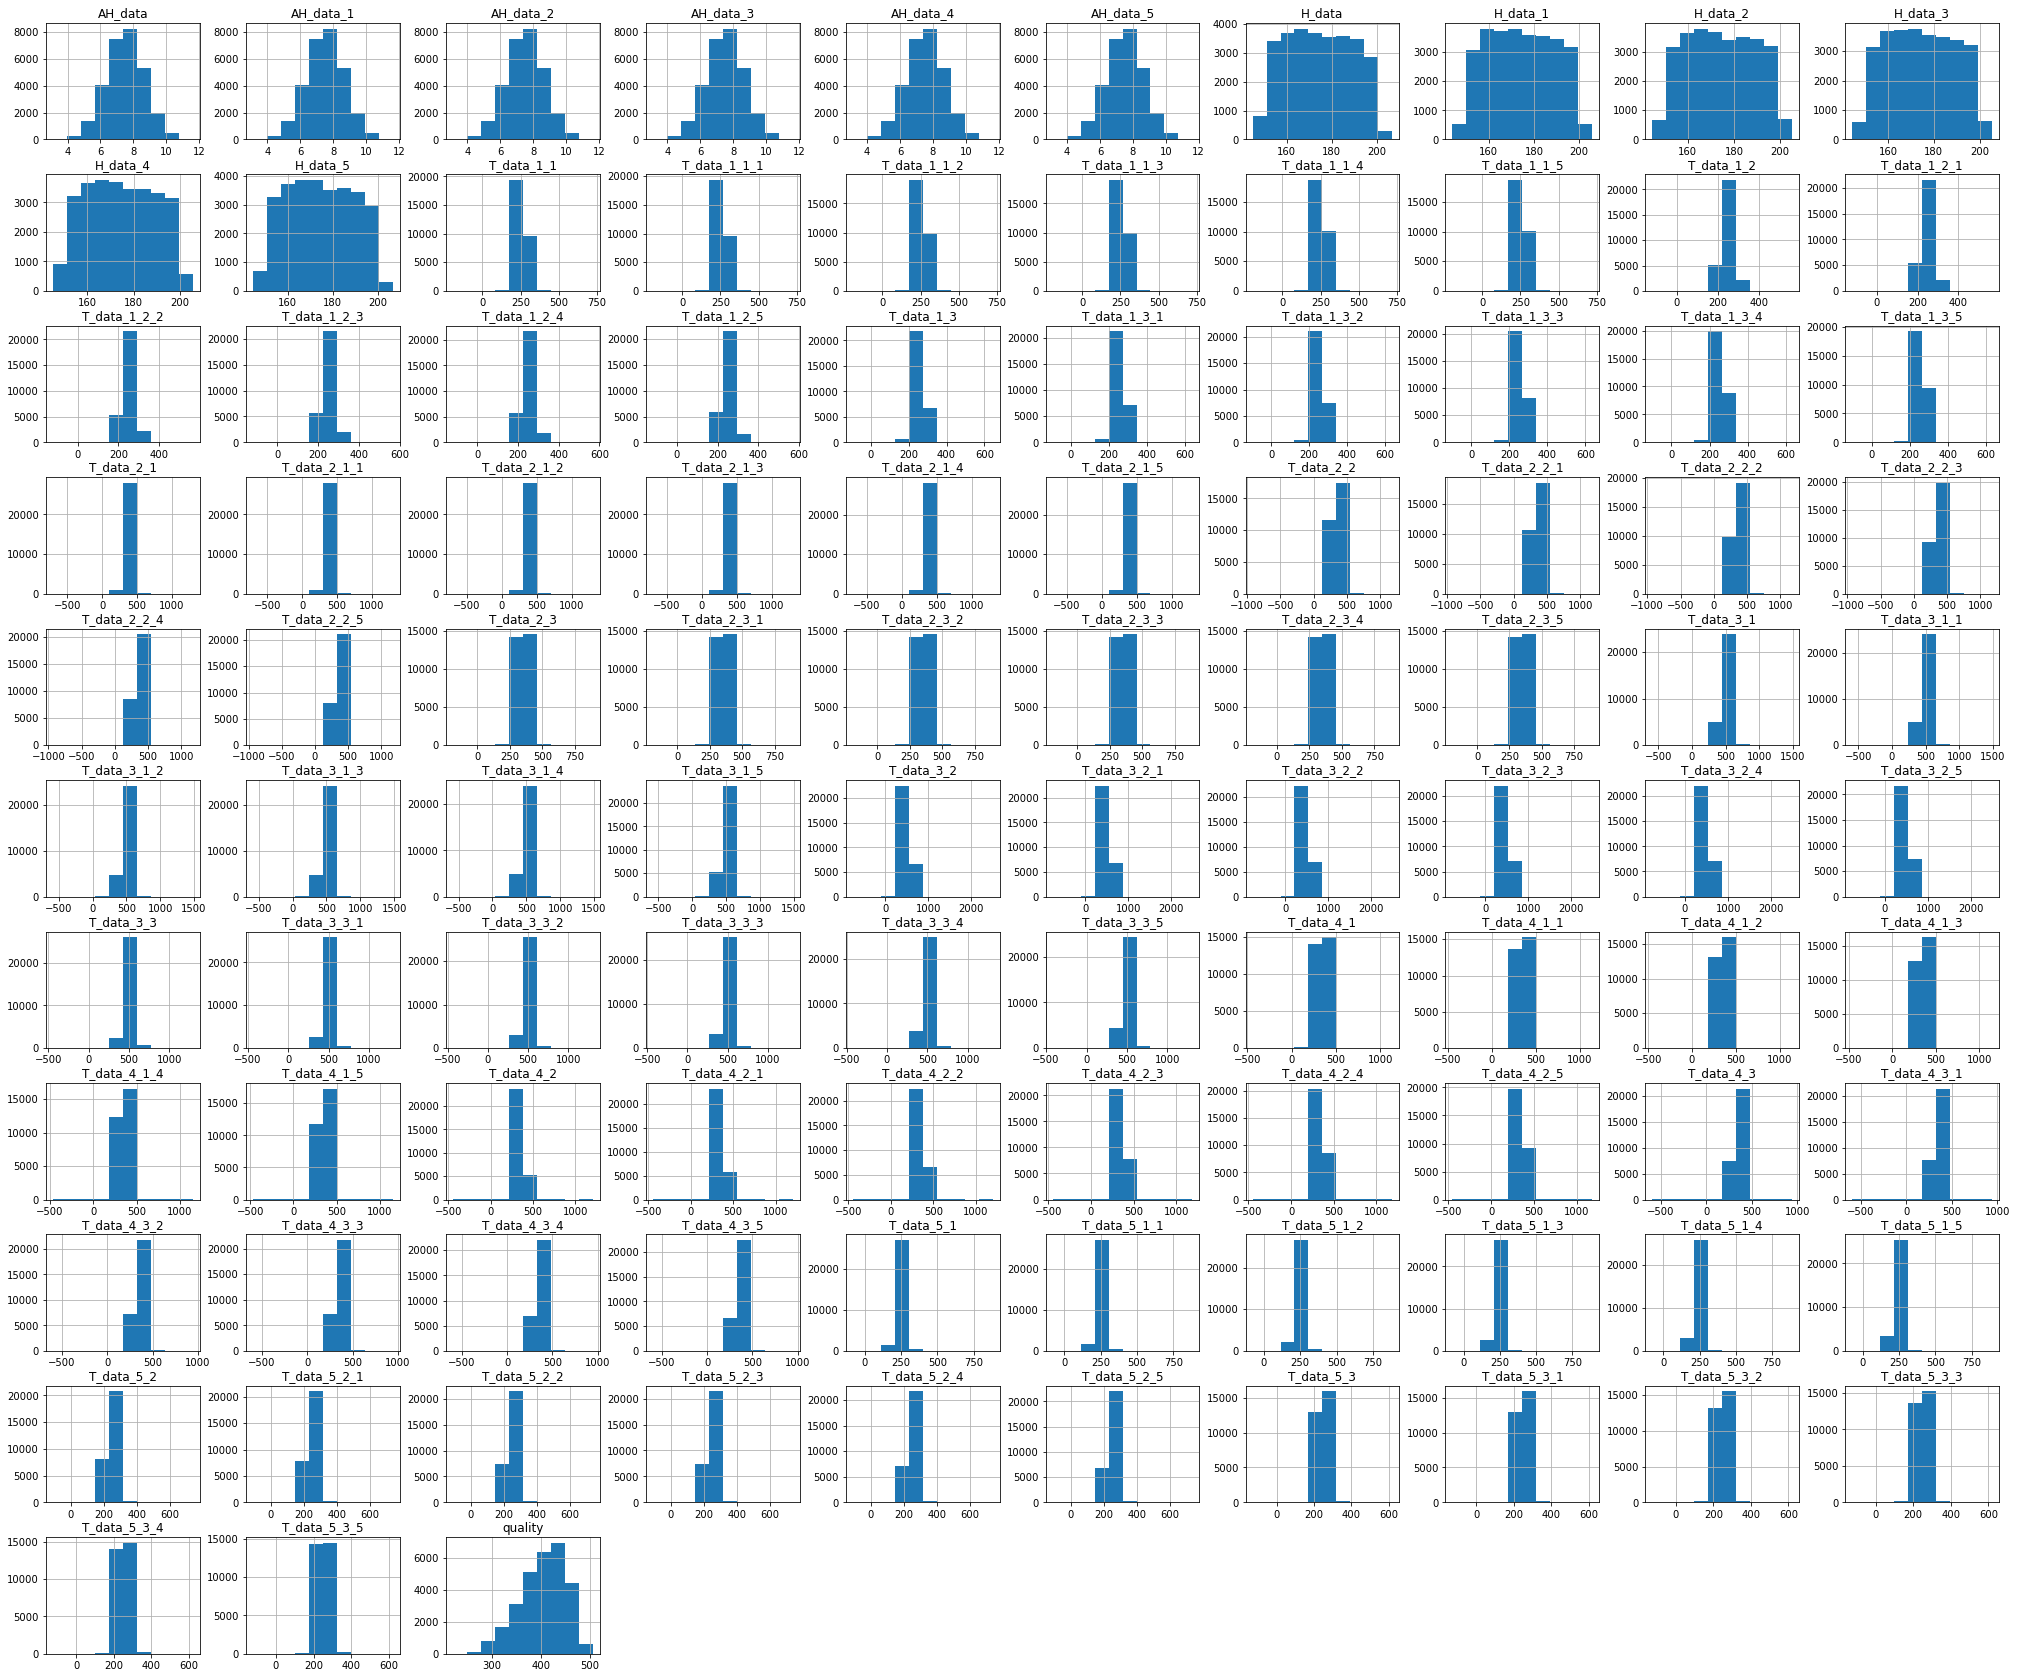

In [28]:
train_df.hist(figsize=(35, 30));

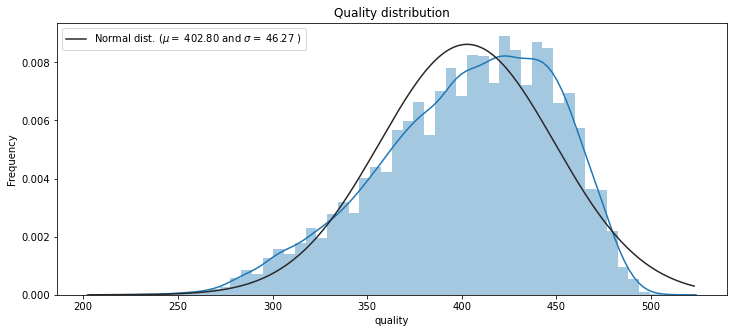

In [29]:
plt.figure(figsize=(12,5))
sns.distplot(train_df['quality'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['quality'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Quality distribution');

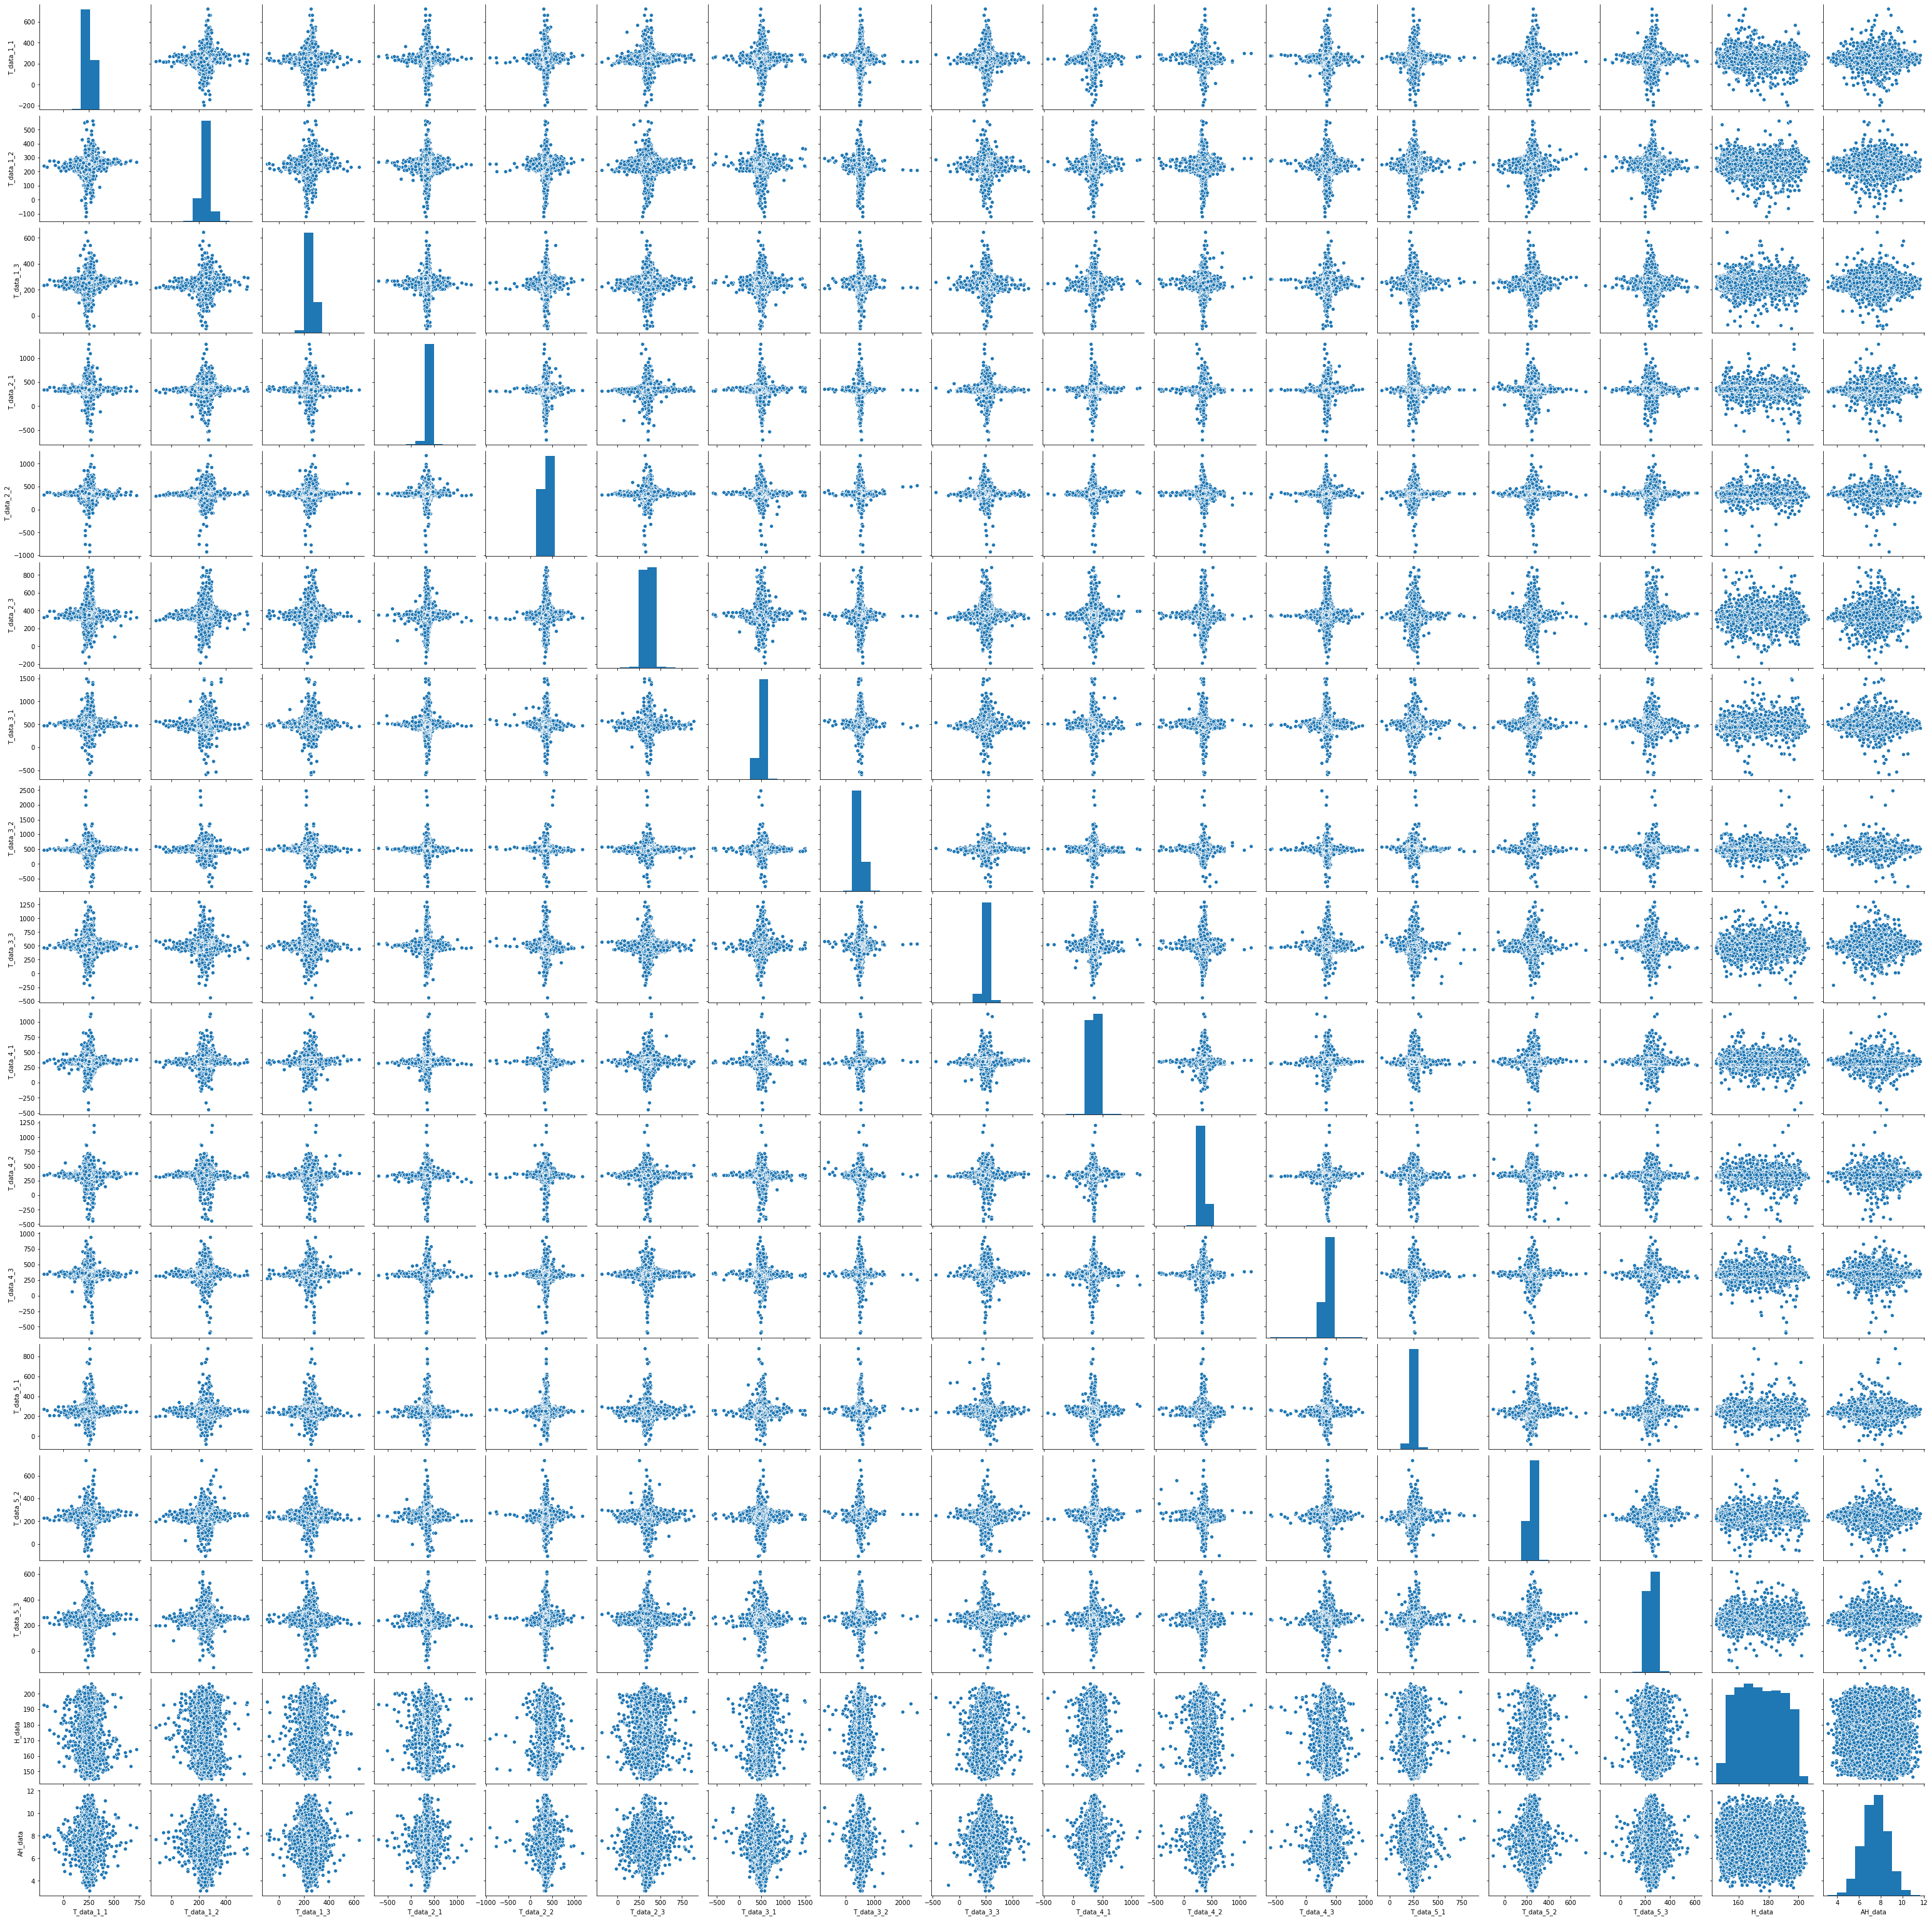

In [30]:
sns.pairplot(data=train_df[data_tmp_columns]);

# Get target

In [31]:
X_test = train_df[train_df['date_time'] >= model_params['test_from']].copy()
train_df = train_df[train_df['date_time'] < model_params['test_from']]

In [32]:
X_test.index = range(X_test.shape[0])
train_df.index = range(train_df.shape[0])

In [33]:
y, y_test = train_df['quality'], X_test['quality']
train_df.drop(['quality'], axis=1, inplace=True)
X_test.drop(['quality'], axis=1, inplace=True)

In [34]:
train_df.drop(['date_time'], axis=1, inplace=True)
X_test.drop(['date_time'], axis=1, inplace=True)
predict_df.drop(['date_time'], axis=1, inplace=True)

# Train test valid split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train_df, y, test_size=0.33, 
                                                  random_state=model_params['seed'])

In [36]:
X_train.shape, X_val.shape, X_test.shape

((17575, 102), (8657, 102), (2952, 102))

In [37]:
y_train.shape, y_val.shape, y_test.shape

((17575,), (8657,), (2952,))

# Scale it

In [38]:
scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_scaled_train = scaler_x.transform(X_train)
X_scaled_val = scaler_x.transform(X_val)
X_scaled_test = scaler_x.transform(X_test)
test_predict_df = scaler_x.transform(predict_df)

In [39]:
scaler_y = StandardScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))
y_scaled_train = scaler_y.transform(y_train.values.reshape(-1, 1))
y_scaled_val = scaler_y.transform(y_val.values.reshape(-1, 1))
y_scaled_test = scaler_y.transform(y_test.values.reshape(-1, 1))
# y_scaled_train = y_train.values.reshape(-1, 1)
# y_scaled_val = y_val.values.reshape(-1, 1)
# y_scaled_test = y_test.values.reshape(-1, 1)

In [40]:
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics

# Baseline

In [41]:

def get_metrics(y_true, y_pred, set_='train', model_='baseline'):
    print('Metrics for model: ' + model_ + ' on ' + set_ + ' dataset. ')
    print('R^2: ', metrics.r2_score(y_true, y_pred) )
    print('Mean absolute error: ', metrics.mean_absolute_error(y_true, y_pred))
    print('Mean squared error: ', metrics.mean_squared_error(y_true, y_pred))
    print('Median absolute error: ', metrics.median_absolute_error(y_true, y_pred))
    print('Mean squared log error: ', metrics.mean_squared_log_error(y_true, y_pred))

In [42]:
average = y_train.mean()
average

403.0364722617354

In [43]:
get_metrics(y_train, [average for l in range(len(y_train))], set_='train', model_='baseline average')
get_metrics(y_val, [average for l in range(len(y_val))], set_='val', model_='baseline average')
get_metrics(y_test, [average for l in range(len(y_test))], set_='test', model_='baseline average')

Metrics for model: baseline average on train dataset. 
R^2:  0.0
Mean absolute error:  37.61076027996253
Mean squared error:  2131.501770769856
Median absolute error:  33.03647226173541
Mean squared log error:  0.014341464052189593
Metrics for model: baseline average on val dataset. 
R^2:  -2.6616616046748476e-06
Mean absolute error:  37.577902403780826
Mean squared error:  2113.247097643556
Median absolute error:  33.96352773826459
Mean squared log error:  0.014198837938221161
Metrics for model: baseline average on test dataset. 
R^2:  -0.0028598709908322917
Mean absolute error:  39.313169864344445
Mean squared error:  2280.852387579764
Median absolute error:  35.96352773826459
Mean squared log error:  0.015698766475012362


In [44]:
median = y_train.median()
median

408.0

In [45]:
get_metrics(y_train, [median for l in range(len(y_train))], set_='train', model_='baseline median')
get_metrics(y_val, [median for l in range(len(y_val))], set_='val', model_='baseline median')
get_metrics(y_test, [median for l in range(len(y_test))], set_='test', model_='baseline median')

Metrics for model: baseline median on train dataset. 
R^2:  -0.011558333165082812
Mean absolute error:  37.40278805120911
Mean squared error:  2156.1383783783785
Median absolute error:  33.0
Mean squared log error:  0.01465957603846286
Metrics for model: baseline median on val dataset. 
R^2:  -0.011308561332224576
Mean absolute error:  37.309229525239694
Mean squared error:  2137.139193716068
Median absolute error:  33.0
Mean squared log error:  0.014510826603828604
Metrics for model: baseline median on test dataset. 
R^2:  -0.024824048519865416
Mean absolute error:  39.25169376693767
Mean squared error:  2330.806571815718
Median absolute error:  35.0
Mean squared log error:  0.016185609008679956


In [46]:
lasso = LassoCV(random_state=model_params['seed'])
lasso.fit(X_scaled_train, y_train)
y_train_pred = lasso.predict(X_scaled_train)
y_val_pred = lasso.predict(X_scaled_val)
y_test_pred = lasso.predict(X_scaled_test)

In [47]:
get_metrics(y_train, y_train_pred, set_='train', model_=' LassoCV')
get_metrics(y_val, y_val_pred, set_='val', model_=' LassoCV')
get_metrics(y_test, y_test_pred, set_='test', model_=' LassoCV')

Metrics for model:  LassoCV on train dataset. 
R^2:  0.7551612551175756
Mean absolute error:  15.31663862641981
Mean squared error:  521.8742182699566
Median absolute error:  10.905106103374465
Mean squared log error:  0.004093663827240375
Metrics for model:  LassoCV on val dataset. 
R^2:  0.7445615916048751
Mean absolute error:  15.389786799874267
Mean squared error:  539.8030383946658
Median absolute error:  11.126473353265851
Mean squared log error:  0.004012508754352765
Metrics for model:  LassoCV on test dataset. 
R^2:  0.758930513322133
Mean absolute error:  16.051831048059114
Mean squared error:  548.2759158750579
Median absolute error:  11.462276450228956
Mean squared log error:  0.004083320266219642


In [48]:
elnet = ElasticNetCV(random_state=model_params['seed'])
elnet.fit(X_scaled_train, y_train)
y_train_pred = elnet.predict(X_scaled_train)
y_val_pred = elnet.predict(X_scaled_val)
y_test_pred = elnet.predict(X_scaled_test)

In [49]:
get_metrics(y_train, y_train_pred, set_='train', model_=' ElasticNetCV')
get_metrics(y_val, y_val_pred, set_='val', model_=' ElasticNetCV')
get_metrics(y_test, y_test_pred, set_='test', model_=' ElasticNetCV')

Metrics for model:  ElasticNetCV on train dataset. 
R^2:  0.7544153569261131
Mean absolute error:  15.373746266986142
Mean squared error:  523.4641015858731
Median absolute error:  10.961006560572343
Mean squared log error:  0.0040868469084744665
Metrics for model:  ElasticNetCV on val dataset. 
R^2:  0.7439622806893634
Mean absolute error:  15.442221994769435
Mean squared error:  541.0695270764925
Median absolute error:  11.21444252587537
Mean squared log error:  0.004024248765556817
Metrics for model:  ElasticNetCV on test dataset. 
R^2:  0.7577458486027318
Mean absolute error:  16.118727668174994
Mean squared error:  550.970255764297
Median absolute error:  11.577711337991815
Mean squared log error:  0.004098540165868746


In [50]:
gb = GradientBoostingRegressor(random_state=model_params['seed'])
gb.fit(X_scaled_train, y_train)
y_train_pred = gb.predict(X_scaled_train)
y_val_pred = gb.predict(X_scaled_val)
y_test_pred = gb.predict(X_scaled_test)

In [51]:
get_metrics(y_train, y_train_pred, set_='train', model_=' GradientBoostingRegressor')
get_metrics(y_val, y_val_pred, set_='val', model_=' GradientBoostingRegressor')
get_metrics(y_test, y_test_pred, set_='test', model_=' GradientBoostingRegressor')

Metrics for model:  GradientBoostingRegressor on train dataset. 
R^2:  0.9183074205410369
Mean absolute error:  9.865133508746625
Mean squared error:  174.12787777553723
Median absolute error:  7.587224070982018
Mean squared log error:  0.0012256855265243619
Metrics for model:  GradientBoostingRegressor on val dataset. 
R^2:  0.9015932539530294
Mean absolute error:  10.636470089622984
Mean squared error:  207.95721696056734
Median absolute error:  8.050951412067434
Mean squared log error:  0.001486552791518999
Metrics for model:  GradientBoostingRegressor on test dataset. 
R^2:  0.899591220331402
Mean absolute error:  11.130254603606357
Mean squared error:  228.36451179846412
Median absolute error:  8.588127575199621
Mean squared log error:  0.0016851764803906006


In [52]:
rf = RandomForestRegressor(random_state=model_params['seed'])
rf.fit(X_scaled_train, y_train)
y_train_pred = rf.predict(X_scaled_train)
y_val_pred = rf.predict(X_scaled_val)
y_test_pred = rf.predict(X_scaled_test)

In [53]:
get_metrics(y_train, y_train_pred, set_='train', model_=' RandomForestRegressor')
get_metrics(y_val, y_val_pred, set_='val', model_=' RandomForestRegressor')
get_metrics(y_test, y_test_pred, set_='test', model_=' RandomForestRegressor')

Metrics for model:  RandomForestRegressor on train dataset. 
R^2:  0.9886870983041943
Mean absolute error:  3.6416546230440963
Mean squared error:  24.11346999715505
Median absolute error:  2.7900000000000205
Mean squared log error:  0.0001747514065441729
Metrics for model:  RandomForestRegressor on val dataset. 
R^2:  0.9159978149845065
Mean absolute error:  9.836516114127297
Mean squared error:  177.51690118978863
Median absolute error:  7.569999999999993
Mean squared log error:  0.001270342086364668
Metrics for model:  RandomForestRegressor on test dataset. 
R^2:  0.9072475806795732
Mean absolute error:  10.602093495934959
Mean squared error:  210.95128360433606
Median absolute error:  8.129999999999995
Mean squared log error:  0.001581882898793387


In [54]:
from sklearn.model_selection import RandomizedSearchCV, KFold
kf = KFold(n_splits=3, random_state=17)

In [65]:
params = {
    'n_estimators':range(150, 250, 5),
    'max_depth': range(3, 7, 1),
    #'min_samples_leaf':range(1, 1000, 100)
}

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=model_params['seed']), param_distributions=params, 
    cv=kf, verbose=1, n_jobs=-1, n_iter=100, scoring='r2'
)
random_search.fit(y_train_pred.reshape(-1, 1), y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=17, shuffle=False),
                   estimator=GradientBoostingRegressor(random_state=777),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(3, 7),
                                        'n_estimators': range(150, 250, 5)},
                   scoring='r2', verbose=1)

In [66]:
random_search.best_params_

{'n_estimators': 150, 'max_depth': 3}

In [67]:
gb = GradientBoostingRegressor(random_state=model_params['seed'], **random_search.best_params_)
gb.fit(X_scaled_train, y_train)
y_train_pred = gb.predict(X_scaled_train)
y_val_pred = gb.predict(X_scaled_val)
y_test_pred = gb.predict(X_scaled_test)

In [68]:
get_metrics(y_train, y_train_pred, set_='train', model_=' GradientBoostingRegressor')
get_metrics(y_val, y_val_pred, set_='val', model_=' GradientBoostingRegressor')
get_metrics(y_test, y_test_pred, set_='test', model_=' GradientBoostingRegressor')

Metrics for model:  GradientBoostingRegressor on train dataset. 
R^2:  0.9237561707595314
Mean absolute error:  9.536752969229093
Mean squared error:  162.5138570363332
Median absolute error:  7.37993189024121
Mean squared log error:  0.0011384227112823395
Metrics for model:  GradientBoostingRegressor on val dataset. 
R^2:  0.9047674175828049
Mean absolute error:  10.43396028265953
Mean squared error:  201.24944273632357
Median absolute error:  7.869271072290815
Mean squared log error:  0.0014357233619805613
Metrics for model:  GradientBoostingRegressor on test dataset. 
R^2:  0.9030522938372887
Mean absolute error:  10.890031392374127
Mean squared error:  220.49282603473813
Median absolute error:  8.298903780356198
Mean squared log error:  0.001617951924465638


In [81]:
1+1

2

In [80]:
obj.lgb_reg.pre

<bound method HPOpt.lgb_reg of <__main__.HPOpt object at 0x0000025E31815100>>

In [110]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

device = get_device()
device

device(type='cpu')

In [131]:
train_target = torch.tensor(y_scaled_train.astype(np.float32))
val_target = torch.tensor(y_scaled_val.astype(np.float32))
test_target = torch.tensor(y_scaled_test.astype(np.float32))

train = torch.tensor(X_train.values.astype(np.float32))
val = torch.tensor(X_val.values.astype(np.float32))
test = torch.tensor(X_test.values.astype(np.float32))

In [132]:
train = train.view(train.shape[0], 1,  window+1, -1)
val = val.view(val.shape[0], 1, window+1, -1)
test = test.view(test.shape[0], 1, window+1, -1)
train.shape, test.shape, val.shape

(torch.Size([19674, 1, 6, 17]),
 torch.Size([2952, 1, 6, 17]),
 torch.Size([6558, 1, 6, 17]))

In [133]:
train_tensor = data_utils.TensorDataset(train, train_target)
val_tensor = data_utils.TensorDataset(val, val_target)
test_tensor = data_utils.TensorDataset(test, test_target)

In [134]:
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = model_params['batch_size'], 
                                     shuffle = True)
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = model_params['batch_size'], 
                                     shuffle = False)
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = model_params['batch_size'], 
                                     shuffle = False)

In [135]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.15,
    ):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.out_channels = out_channels
        
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, 
                                kernel_size=(kernel_sizes[0], emb_dim), padding=1, stride=2)
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, 
                                kernel_size=(kernel_sizes[1], emb_dim), padding=1, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, 
                                kernel_size=(kernel_sizes[2], emb_dim), padding=1, stride=2)

        self.fc_1 = nn.Linear(len(kernel_sizes) * out_channels, 128)
        self.fc_2 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        batch_size = text.shape[0]
        
        conved_0 = F.tanh(self.conv_0(text)).view(batch_size, self.out_channels, -1)
        conved_1 = F.tanh(self.conv_1(text)).view(batch_size, self.out_channels, -1)
        conved_2 = F.tanh(self.conv_2(text)).view(batch_size, self.out_channels, -1)
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        
        lin = F.leaky_relu(self.fc_1(cat))
        lin = self.fc_2(lin)
            
        return lin

In [136]:
next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape

(torch.Size([64, 1, 6, 17]), torch.Size([64, 1]))

In [137]:
kernel_sizes = [3, 5, 6]
vocab_size = next(iter(train_loader))[0].shape[-1]
out_channels = 8
dropout = 0.25
dim = next(iter(train_loader))[0].shape[-2]

model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [138]:
model.to(device)

CNN(
  (conv_0): Conv2d(1, 8, kernel_size=(3, 6), stride=(2, 2), padding=(1, 1))
  (conv_1): Conv2d(1, 8, kernel_size=(5, 6), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(1, 8, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  (fc_1): Linear(in_features=24, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [139]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [140]:
max_epochs = 50

In [141]:
scheduler = ExponentialLR(opt, gamma=0.9999)

In [142]:
min_loss = np.inf

cur_patience = 0
patience=5

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        X_train_b, y_train_b = batch[0].to(device), batch[1].to(device)
        opt.zero_grad()
        
        answers_train = model(X_train_b)
        
        loss = loss_func(answers_train.squeeze(), y_train_b)
        loss.backward()
        
        scheduler.step()
        
        opt.step()
        train_loss += loss

    train_loss /= len(train_loader)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    with torch.no_grad():
        for it, batch in pbar:
            X_val_b, y_val_b = batch[0].to(device), batch[1].to(device)

            answers_val = model(X_val_b)
            val_loss += loss_func(answers_val.squeeze(), y_val_b)
            
    val_loss /= len(val_loader)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 10933.021484375, Validation Loss: 12624.3349609375


Epoch: 2, Training Loss: 3257.273193359375, Validation Loss: 14559.478515625


Epoch: 3, Training Loss: 2984.3515625, Validation Loss: 13892.576171875


Epoch: 4, Training Loss: 2916.7822265625, Validation Loss: 13001.4609375


Epoch: 5, Training Loss: 2798.28466796875, Validation Loss: 12927.166015625


<All keys matched successfully>

In [143]:
with torch.no_grad():
    y_test_pred = model(test).detach().numpy()

In [144]:
test_target.detach().numpy(), y_test_pred

(array([[441.],
        [449.],
        [449.],
        ...,
        [455.],
        [455.],
        [454.]], dtype=float32),
 array([[310.26083],
        [308.1757 ],
        [295.1312 ],
        ...,
        [283.25342],
        [288.56247],
        [286.95187]], dtype=float32))